# Synthetic Image Generator

Usage Example
~~~
# ============================
# Example usage
# ============================
gen = SyntheticImageGenerator(
    output_dir='./synthetic_data',
    height=256,
    width=256,
    num_channels=8,
    background_intensity=0,
    dtype='uint16',
    direct_write=False  # ← keep this False during development!
)

# This square is HUGE and off-center → will be cropped
img = gen.generate_image(
    file_name='huge_offcenter',
    square_params={
        'side_length': 400,           # bigger than image!
        'center': (50, 200)              # way off-center
    },
    gradient_params={
        'start_intensity': 500,
        'end_intensity': 3000
    }
)


# Batch example with some oversized squares
batch = [
    {'square_params': {'side_length': 128}, 'gradient_params': {'start_intensity': 200, 'end_intensity': 1000}},
    {'square_params': {'side_length': 300, 'center': (100, 100)}, 'gradient_params': {'start_intensity': 400, 'end_intensity': 2000}},
    {'square_params': {'side_length': 512}, 'gradient_params': {'start_intensity': 150, 'end_intensity': 800}},
]

images = gen.generate_batch(batch, base_name='crop_test')
print(f"Generated {len(images)} images, all returned as numpy arrays for inspection")
~~~

In [113]:
import numpy as np
import tifffile
from pathlib import Path
from typing import Dict, Union, Optional, Tuple, List, Callable
import warnings
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


class SyntheticImageGenerator:
    """
    Enhanced synthetic multi-channel image generator with morphing capabilities.
    
    Key features:
    - Unified gradient system for morphing any parameter
    - Support for squares, circles/ellipses
    - Extensible for future rotation support
    - Spatial and channel noise simulation
    """

    def __init__(
        self,
        output_dir: Union[str, Path],
        height: int,
        width: int,
        num_channels: int,
        background_intensity: float,
        dtype: str = 'uint16',
        direct_write: bool = False
    ):
        if height <= 0 or width <= 0 or num_channels <= 0:
            raise ValueError("height, width, and num_channels must be positive")

        self.output_dir = output_dir
        self.height = int(height)
        self.width = int(width)
        self.num_channels = int(num_channels)
        self.background_intensity = float(background_intensity)
        self.dtype = np.dtype(dtype)
        self.direct_write = bool(direct_write)

        if self.direct_write:
            os.makedirs(self.output_dir, exist_ok=True)
        self._validate_intensity(background_intensity, "background_intensity")

    def _validate_intensity(self, intensity: float, name: str) -> None:
        """Validate intensity values are within dtype range."""
        if np.issubdtype(self.dtype, np.integer):
            info = np.iinfo(self.dtype)
            if not (info.min <= intensity <= info.max):
                raise ValueError(f"{name}={intensity} out of range for {self.dtype}")
        else:
            info = np.finfo(self.dtype)
            if abs(intensity) > info.max * 0.99:
                warnings.warn(f"{name}={intensity} close to or beyond {self.dtype} limits")

    def sample_gradient(
        self,
        start_value: Union[float, Tuple[float, ...]],
        end_value: Union[float, Tuple[float, ...]],
        noise_std: float = 0.0,
        min_clip: Optional[Union[float, Tuple[float, ...]]] = None,
        max_clip: Optional[Union[float, Tuple[float, ...]]] = None
    ) -> np.ndarray:
        """
        Universal gradient sampler for morphing any parameter across channels.
        
        This is the core function that handles ALL morphing operations.
        
        Parameters
        ----------
        start_value : float or tuple
            Starting value(s) at channel 0
        end_value : float or tuple
            Ending value(s) at last channel
        noise_std : float
            Standard deviation of Gaussian noise to add per channel
        min_clip : float or tuple, optional
            Minimum allowed value(s) after noise
        max_clip : float or tuple, optional
            Maximum allowed value(s) after noise
            
        Returns
        -------
        np.ndarray
            Shape (num_channels,) for scalar or (num_channels, n_dims) for tuples
            
        Examples
        --------
        # Morph intensity from 100 to 800
        intensities = gen.sample_gradient(100, 800, noise_std=5)
        
        # Morph size from (50, 50) to (100, 80) with noise
        sizes = gen.sample_gradient((50, 50), (100, 80), noise_std=2)
        
        # Morph position from center to offset
        positions = gen.sample_gradient((128, 128), (140, 120), noise_std=1)
        """
        # Convert to arrays for unified handling
        start = np.atleast_1d(start_value)
        end = np.atleast_1d(end_value)
        
        if start.shape != end.shape:
            raise ValueError(f"start and end must have same shape: {start.shape} vs {end.shape}")
        
        n_dims = start.shape[0]
        
        # Create linear interpolation for each dimension
        gradient = np.zeros((self.num_channels, n_dims))
        for dim in range(n_dims):
            gradient[:, dim] = np.linspace(start[dim], end[dim], self.num_channels)
        
        # Add noise if requested
        if noise_std > 0:
            noise = np.random.normal(0, noise_std, size=gradient.shape)
            gradient += noise
        
        # Apply clipping
        if min_clip is not None:
            min_clip_arr = np.atleast_1d(min_clip)
            gradient = np.maximum(gradient, min_clip_arr)
        
        if max_clip is not None:
            max_clip_arr = np.atleast_1d(max_clip)
            gradient = np.minimum(gradient, max_clip_arr)
        
        # Return scalar array if input was scalar
        if n_dims == 1:
            return gradient.ravel()
        return gradient

    def _rotated_coords(
        self,
        center_y: float,
        center_x: float,
        rotation: float
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Return rotated (and translated) coordinate arrays.
        
        Applies: translate → rotate (inverse) so that a shape defined in
        axis-aligned local coordinates appears rotated in image space.
        
        Returns
        -------
        dx_rot, dy_rot : np.ndarray
            Coordinate arrays in the local, axis-aligned system of the shape
        """
        theta = np.deg2rad(rotation)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
    
        y, x = np.mgrid[0:self.height, 0:self.width]
    
        dy = y - center_y
        dx = x - center_x
    
        # Inverse rotation (rotates coordinate system, not the shape)
        dx_rot =  cos_t * dx + sin_t * dy
        dy_rot = -sin_t * dx + cos_t * dy
    
        return dx_rot, dy_rot

    def _draw_square_mask(
        self,
        size_y: float,
        size_x: float,
        center_y: float,
        center_x: float,
        rotation: float = 0.0
    ) -> np.ndarray:
        if size_y <= 0 or size_x <= 0:
            return np.zeros((self.height, self.width), dtype=bool)
    
        dx_rot, dy_rot = self._rotated_coords(center_y, center_x, rotation)
    
        half_y = size_y / 2.0
        half_x = size_x / 2.0
    
        return (np.abs(dx_rot) <= half_x) & (np.abs(dy_rot) <= half_y)

    def _draw_circle_mask(
        self,
        size_y: float,
        size_x: float,
        center_y: float,
        center_x: float,
        rotation: float = 0.0
    ) -> np.ndarray:
        if size_y <= 0 or size_x <= 0:
            return np.zeros((self.height, self.width), dtype=bool)
    
        dx_rot, dy_rot = self._rotated_coords(center_y, center_x, rotation)
    
        a = size_x / 2.0   # semi-axis along original x
        b = size_y / 2.0   # semi-axis along original y
    
        return (dx_rot / a)**2 + (dy_rot / b)**2 <= 1.0

    def _draw_shape_mask(
        self,
        shape_type: str,
        size_y: float,
        size_x: float,
        center_y: float,
        center_x: float,
        rotation: float = 0.0,
        blur_sigma: float = 0.0,
    ) -> np.ndarray:
        """Dispatch to appropriate shape drawing function."""
        # 1. Draw mask with correct shape
        shape_type = shape_type.lower()
        if shape_type in ['square', 'rectangle']:
            mask = self._draw_square_mask(size_y, size_x, center_y, center_x, rotation)
        elif shape_type in ['circle', 'ellipse']:
            mask = self._draw_circle_mask(size_y, size_x, center_y, center_x, rotation)
        else:
            warnings.warn(f"Unknown shape '{shape_type}', defaulting to rectangle")
            mask = self._draw_square_mask(size_y, size_x, center_y, center_x, rotation)

        mask = mask.astype(np.float32)

        # 2. Apply Gaussian Blur if sigma > 0
        if blur_sigma > 0:
            mask = gaussian_filter(mask, sigma=blur_sigma)
            # Clip to ensure intensities remain between 0 and 1 after blur
            np.clip(mask, 0.0, 1.0, out=mask) 
            
        return mask

    def generate_image(
        self,
        file_name: str,
        shape_params: Dict,
        gradient_params: Dict,
        metadata: Optional[Dict] = None
    ) -> Union[Path, np.ndarray]:
        """
        Generate a single synthetic image with optional morphing.
        
        Parameters
        ----------
        file_name : str
            Output filename
        shape_params : dict
            Must contain:
            - 'shape_type': 'square', 'circle', etc.
            - 'size': scalar or (size_y, size_x) tuple for start size
            - 'size_end': (optional) end size for morphing
            - 'center': (center_y, center_x) for start position
            - 'center_end': (optional) end position for morphing
            - 'rotation': (optional) rotation angle in degrees (future use)
            - 'rotation_delta': (optional) end rotation for morphing (future use)
            - 'spatial_noise_std': noise to add to size/position per channel
        gradient_params : dict
            Must contain:
            - 'start_intensity': starting intensity
            - 'end_intensity': ending intensity
            - 'channel_noise_std': noise to add to intensity per channel
        metadata : dict, optional
            Additional TIFF metadata
            
        Returns
        -------
        Path or np.ndarray
            File path if direct_write=True, otherwise the image array
        """
        # Parse shape parameters
        shape_type = shape_params.get('shape_type', 'square').lower()
        
        # Parse size
        size_start = shape_params['size']
        if isinstance(size_start, (int, float)):
            size_start = (float(size_start), float(size_start))
        else:
            size_start = tuple(float(x) for x in size_start)
        
        size_end = shape_params.get('size_end', size_start)
        if isinstance(size_end, (int, float)):
            size_end = (float(size_end), float(size_end))
        else:
            size_end = tuple(float(x) for x in size_end)

        
        # Parse center
        center_start = shape_params.get('center', (self.height // 2, self.width // 2))
        if center_start is None or center_start == (None, None):
            center_start = (self.height // 2, self.width // 2)
        center_start = tuple(float(x) for x in center_start)
        
        center_end = shape_params.get('center_end', center_start)
        if center_end is None or center_end == (None, None):
            center_end = center_start
        center_end = tuple(float(x) for x in center_end)
        
        # Parse rotation (reserved for future use)
        rotation_start = shape_params.get('rotation', 0.0)
        rotation_delta = shape_params.get('rotation_delta', 0.0)
        rotation_end = rotation_start + rotation_delta
        
        # Get noise parameters
        spatial_noise_std = shape_params.get('spatial_noise_std', 0.0)
        blur_sigma = shape_params.get('blur_sigma', 0.0)
        photon_scale = gradient_params.get('photon_scale', 100.0)
        
        # Parse gradient parameters
        start_intensity = gradient_params['start_intensity']
        end_intensity = gradient_params['end_intensity']
        channel_noise_std = gradient_params.get('channel_noise_std', 0.0)
        
        # === Generate all gradients using unified sample_gradient ===
        
        # 1. Intensity gradient
        if np.issubdtype(self.dtype, np.integer):
            iinfo = np.iinfo(self.dtype)
            intensity_min, intensity_max = iinfo.min, iinfo.max
        else:
            intensity_min, intensity_max = 0.0, 1.0
        
        intensities = self.sample_gradient(
            start_intensity,
            end_intensity,
            noise_std=channel_noise_std,
            min_clip=intensity_min,
            max_clip=intensity_max
        )
        
        # 2. Size gradient (morphing size across channels)
        sizes = self.sample_gradient(
            size_start,
            size_end,
            noise_std=spatial_noise_std,
            min_clip=(1.0, 1.0),  # Prevent negative sizes
            max_clip=None
        )
        
        # 3. Position gradient (morphing position across channels)
        centers = self.sample_gradient(
            center_start,
            center_end,
            noise_std=spatial_noise_std,
            min_clip=None,
            max_clip=None
        )
        
        # 4. Rotation gradient
        rotations = self.sample_gradient(
            rotation_start,
            rotation_end,
            noise_std=0.0,  # Could add rotation noise in future
            min_clip=None,
            max_clip=None
        )
        
        # Validate intensities
        self._validate_intensity(float(np.max(intensities)), 'max_intensity')
        self._validate_intensity(float(np.min(intensities)), 'min_intensity')
        
        # Create empty image
        image = np.full(
            (self.num_channels, self.height, self.width),
            self.background_intensity,
            dtype=self.dtype
        )
        
        # Draw shape for each channel with morphed parameters
        for c in range(self.num_channels):
            size_y, size_x = sizes[c]
            center_y, center_x = centers[c]
            rotation = rotations[c]
            intensity = intensities[c]
            
            # Get mask for current channel
            mask = self._draw_shape_mask(
                shape_type,
                size_y,
                size_x,
                center_y,
                center_x,
                rotation,
                blur_sigma,
            )
            
            # Apply intensity
            # New intensity = Background + (Intensity - Background) * Mask
            diff = intensity - self.background_intensity
            
            # Apply soft mask to the channel image
            image[c] = self.background_intensity + diff * mask

        image = self._add_poisson_noise(image, photon_scale)
        
        # Final cast
        image = image.astype(self.dtype, copy=False)
        
        # Save or return
        if self.direct_write:
            if not str(file_name).lower().endswith(('.tif', '.tiff')):
                file_name = f"{file_name}.tif"
            output_path = self.output_dir / file_name
            
            tiff_metadata = {
                'axes': 'CYX',
                'Channel': {'Name': [f'Channel_{i}' for i in range(self.num_channels)]},
                'ImageDescription': (
                    f'Synthetic: {self.num_channels}C {self.height}x{self.width}, '
                    f'shape={shape_type}, '
                    f'size_morph={size_start}→{size_end}, '
                    f'center_morph={center_start}→{center_end}, '
                    f'intensity={start_intensity:.1f}→{end_intensity:.1f}'
                )
            }
            if metadata:
                tiff_metadata.update(metadata)
            
            tifffile.imwrite(
                output_path,
                image,
                photometric='minisblack',
                metadata=tiff_metadata
            )
            return output_path
        else:
            return image

    def generate_batch(
        self,
        batch_params: List[Dict],
        base_name: str = 'image',
        verbose: bool = True
    ) -> List[Union[Path, np.ndarray]]:
        """Generate multiple images with different parameters."""
        results = []
        
        for idx, params in enumerate(batch_params):
            file_name = f"{base_name}_{idx:04d}"
            
            if verbose:
                shape_info = params['shape_params']
                size = shape_info.get('size', 'unknown')
                shape_type = shape_info.get('shape_type', 'square')
                print(f"Generating {idx+1}/{len(batch_params)}: {file_name} "
                      f"({shape_type}, size={size})")
            
            result = self.generate_image(
                file_name=file_name,
                shape_params=params['shape_params'],
                gradient_params=params['gradient_params'],
                metadata=params.get('metadata')
            )
            results.append(result)
        
        if verbose:
            mode = "saved to disk" if self.direct_write else "returned as arrays"
            print(f"\nBatch complete: {len(results)} images {mode}")
        
        return results

    def create_morph_sequence(
        self,
        shape_type: str,
        size_start: Union[float, Tuple[float, float]],
        size_end: Union[float, Tuple[float, float]],
        center_start: Optional[Tuple[float, float]] = None,
        center_end: Optional[Tuple[float, float]] = None,
        intensity_start: float = 200.0,
        intensity_end: float = 800.0,
        rotation_start: float = 0.0,
        rotation_delta: float = 0.0,
        spatial_noise_std: float = 0.0,
        channel_noise_std: float = 0.0,
        blur_sigma: float = 0.0,
        photon_scale: float = 100.0
    ) -> Dict:
        """
        Convenience method to create a single morphing sequence configuration.
        
        This creates the parameter dictionary needed for generate_image() that
        will morph the shape from start to end parameters across channels.
        
        Parameters
        ----------
        shape_type : str
            'square', 'circle', etc.
        size_start, size_end : float or tuple
            Starting and ending sizes
        center_start, center_end : tuple, optional
            Starting and ending positions (defaults to image center)
        intensity_start, intensity_end : float
            Starting and ending intensities
        rotation_start, rotation_delta : float
            Starting rotation angle and rotation delta (+/-)
        spatial_noise_std : float
            Spatial noise to add per channel
        channel_noise_std : float
            Intensity noise to add per channel
            
        Returns
        -------
        dict
            Configuration dictionary for generate_image()
            
        Examples
        --------
        # Create a circle that grows and moves
        config = gen.create_morph_sequence(
            shape_type='circle',
            size_start=30,
            size_end=80,
            center_start=(128, 128),
            center_end=(150, 140),
            intensity_start=200,
            intensity_end=600
        )
        image = gen.generate_image('morph_test', **config)
        """
        if center_start is None:
            center_start = (self.height // 2, self.width // 2)
        if center_end is None:
            center_end = center_start
        
        return {
            'shape_params': {
                'shape_type': shape_type,
                'size': size_start,
                'size_end': size_end,
                'center': center_start,
                'center_end': center_end,
                'rotation': rotation_start,
                'rotation_delta': rotation_delta,
                'spatial_noise_std': spatial_noise_std,
                'blur_sigma': blur_sigma,
            },
            'gradient_params': {
                'start_intensity': intensity_start,
                'end_intensity': intensity_end,
                'channel_noise_std': channel_noise_std,
                'photon_scale': photon_scale,
            }
        }

    def create_random_morph_batch(
        self,
        batch_size: int,
        param_distributions: Dict[str, Dict]
    ) -> List[Dict]:
        """
        Create random morphing sequences by sampling start AND end values.
        
        This extends the sampling to morphing by allowing you to specify
        distributions for both start and end values of any parameter.
        
        Parameters
        ----------
        batch_size : int
            Number of sequences to generate
        param_distributions : dict
            Configuration for sampling. Each key can have:
            - For non-morphing: standard distribution config
            - For morphing: add '_end' suffix for end value distribution
            
        Examples
        --------
        # Create batch with random size morphing
        batch = gen.create_random_morph_batch(10, {
            'shape_type': {'dist': 'choice', 'options': ['square', 'circle']},
            'size': {'dist': 'uniform', 'min': 30, 'max': 50},
            'size_end': {'dist': 'uniform', 'min': 60, 'max': 100},
            'intensity': {'dist': 'uniform', 'min': 200, 'max': 400},
            'intensity_end': {'dist': 'uniform', 'min': 500, 'max': 800}
        })
        """
        def _sample(dist_config, size):
            dist_type = dist_config['dist'].lower()
            
            if dist_type == 'uniform':
                return np.random.uniform(dist_config['min'], dist_config['max'], size)
            elif dist_type == 'normal':
                return np.abs(np.random.normal(dist_config['mean'], dist_config['std'], size))
            elif dist_type == 'fixed':
                return np.full(size, dist_config['value'])
            elif dist_type == 'choice':
                return np.random.choice(dist_config['options'], size)
            elif dist_type == 'dual':
                dist_1 = np.abs(np.random.normal(dist_config['mean_1'], dist_config['std_1'], size))
                dist_2 = np.abs(np.random.normal(dist_config['mean_2'], dist_config['std_2'], size))
                size_array = np.column_stack((dist_1, dist_2))
                return [tuple(size) for size in size_array]
            else:
                raise ValueError(f"Unknown distribution: {dist_type}")
        
        # Default configurations
        defaults = {
            'shape_type':       {'dist': 'fixed', 'value': 'square'},
            
            # Size (start and optional end)
            'size':             {'dist': 'uniform', 'min': 30,  'max': 80},
            'size_end':         {'dist': 'uniform', 'min': 30,  'max': 120},  # optional override
            
            # Intensity
            'intensity':        {'dist': 'uniform', 'min': 200, 'max': 400},
            'intensity_end':    {'dist': 'uniform', 'min': 500, 'max': 800},
            
            # Center position (start)
            'center_x':         {'dist': 'fixed', 'value': None},  # None → will use image center
            'center_y':         {'dist': 'fixed', 'value': None},
            
            # Center end position (for moving objects)
            'center_x_end':     {'dist': 'fixed', 'value': None},
            'center_y_end':     {'dist': 'fixed', 'value': None},
            
            # Rotation
            'rotation':         {'dist': 'uniform', 'min': 0.0,   'max': 360.0},
            'rotation_delta':   {'dist': 'fixed',  'value': 0.0},
            
            # Noise & effects
            'spatial_noise_std': {'dist': 'fixed', 'value': 0.0},
            'channel_noise_std': {'dist': 'fixed', 'value': 0.0},
            'blur_sigma':        {'dist': 'fixed', 'value': 0.0},
            'photon_scale':      {'dist': 'fixed', 'value': 0.0},
        }
        
        # Merge with user config
        config = {**defaults, **param_distributions}
        
        # Sample all parameters
        samples = {}
        for key, dist_config in config.items():
            samples[key] = _sample(dist_config, batch_size)
        
        # Build batch instructions
        batch = []
        for i in range(batch_size):
            # Get base values
            shape_type = samples['shape_type'][i]
            size_start = samples['size'][i]
            
            # Handle size_end - if not sampled, use size_start
            if 'size_end' in samples:
                size_end = samples['size_end'][i]
            else:
                size_end = size_start
            
            # Handle centers
            center_y = samples.get('center_y', np.full(batch_size, self.height // 2))[i]
            center_x = samples.get('center_x', np.full(batch_size, self.width // 2))[i]
            
            # Handle center_end - if not sampled, use center_start
            if 'center_y_end' in samples:
                center_y_end = samples['center_y_end'][i]
            else:
                center_y_end = center_y
            
            if 'center_x_end' in samples:
                center_x_end = samples['center_x_end'][i]
            else:
                center_x_end = center_x
            
            intensity_start = samples['intensity'][i]
            intensity_end = samples['intensity_end'][i]
            
            # Handle rotation
            rotation_start = samples.get('rotation', np.zeros(batch_size))[i]
            
            if 'rotation_delta' in samples:
                rotation_delta = samples['rotation_delta'][i]
            else:
                rotation_delta = 0.0
            
            spatial_noise = samples['spatial_noise_std'][i]
            channel_noise = samples['channel_noise_std'][i]

            blur_sigma = samples['blur_sigma'][i]
            photon_scale = samples['photon_scale'][i]
            
            # Create instruction
            instruction = {
                'shape_params': {
                    'shape_type': shape_type,
                    'size': size_start,
                    'size_end': size_end,
                    'center': (center_y, center_x),
                    'center_end': (center_y_end, center_x_end),
                    'rotation': rotation_start,
                    'rotation_delta': rotation_delta,
                    'spatial_noise_std': spatial_noise,
                    'blur_sigma': blur_sigma
                },
                'gradient_params': {
                    'start_intensity': intensity_start,
                    'end_intensity': intensity_end,
                    'channel_noise_std': channel_noise,
                    'photon_scale': photon_scale
                }
            }
            batch.append(instruction)
        
        return batch

    # Add this method inside the SyntheticImageGenerator class
    def _add_poisson_noise(self, image_array: np.ndarray, photon_scale: float = 100.0) -> np.ndarray:
        """
        Applies realistic photon (Poisson) noise.
        
        The key insight: photon_scale represents the intensity value that corresponds
        to collecting ~1 photon on average. Higher photon_scale = more photons per 
        intensity unit = LESS noise (better SNR).
        
        Parameters
        ----------
        image_array : np.ndarray
            The clean image array (C, Y, X).
        photon_scale : float
            Intensity value corresponding to ~1 expected photon. 
            - photon_scale=1: very noisy (1 photon per intensity unit)
            - photon_scale=100: moderate noise (100 photons per 100 intensity units)
            - photon_scale=1000: low noise (1000 photons per 1000 intensity units)
        
        Returns
        -------
        np.ndarray
            The image with added Poisson noise.
        """
        if photon_scale <= 0:
            warnings.warn("Photon scale must be positive, skipping Poisson noise.")
            return image_array
    
        # Convert to float for calculation
        image_float = image_array.astype(np.float64)
        
    
        mean_photons = image_float / photon_scale
        
        # Ensure non-negative (shouldn't happen, but safety check)
        mean_photons = np.maximum(mean_photons, 0)
        
        # Sample Poisson noise
        noisy_photons = np.random.poisson(mean_photons)
        
        # Convert back to intensity
        noisy_image = noisy_photons * photon_scale
        
        # Clip to dtype range
        if np.issubdtype(self.dtype, np.integer):
            info = np.iinfo(self.dtype)
            noisy_image = np.clip(noisy_image, info.min, info.max)
        
        return noisy_image.astype(self.dtype)


    def preview_noise_comparison(
        self,
        test_intensity: float = 500.0,
        photon_scales: list = None,
        blur_sigmas: list = None,
        shape_size: float = 50.0
    ) -> None:
        """
        Generate comparison plots to visualize noise effects.
        
        Parameters
        ----------
        test_intensity : float
            Test intensity value for the shape
        photon_scales : list
            List of photon_scale values to compare (default: [10, 100, 1000])
        blur_sigmas : list  
            List of blur_sigma values to compare (default: [0, 1, 3, 5])
        shape_size : float
            Size of test shape
        """
        import matplotlib.pyplot as plt
        
        if photon_scales is None:
            photon_scales = [10, 100, 1000, 10000]
        if blur_sigmas is None:
            blur_sigmas = [0, 1, 3, 5]
        
        # Create test configuration
        test_config = self.create_morph_sequence(
            shape_type='circle',
            size_start=shape_size,
            size_end=shape_size,
            intensity_start=test_intensity,
            intensity_end=test_intensity,
            spatial_noise_std=0.0,
            channel_noise_std=0.0
        )
        
        # Test Poisson noise
        fig, axes = plt.subplots(1, len(photon_scales), figsize=(4*len(photon_scales), 4))
        fig.suptitle(f'Poisson Noise Comparison (Intensity={test_intensity})', fontsize=14)
        
        for idx, scale in enumerate(photon_scales):
            test_config['gradient_params']['photon_scale'] = scale
            img = self.generate_image('test', **test_config)
            
            # Show middle channel
            mid_channel = img.shape[0] // 2
            axes[idx].imshow(img[mid_channel], cmap='gray', vmin=0, vmax=self.dtype.type(1000))
            axes[idx].set_title(f'photon_scale={scale}\nSNR≈{np.sqrt(test_intensity/scale):.1f}')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Test Gaussian blur
        fig, axes = plt.subplots(1, len(blur_sigmas), figsize=(4*len(blur_sigmas), 4))
        fig.suptitle('Gaussian Blur Comparison', fontsize=14)
        
        test_config['gradient_params']['photon_scale'] = 10  # Minimal Poisson noise
        
        for idx, sigma in enumerate(blur_sigmas):
            test_config['shape_params']['blur_sigma'] = sigma
            img = self.generate_image('test', **test_config)
            
            mid_channel = img.shape[0] // 2
            axes[idx].imshow(img[mid_channel], cmap='gray', vmin=0, vmax=self.dtype.type(1000))
            axes[idx].set_title(f'blur_sigma={sigma}')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()


In [114]:
def show(img):
    """Quickly visualize all channels of a synthetic image returned by your generator"""
    plt.figure(figsize=(12, 8))
    for c in range(img.shape[0]):
        plt.subplot(2, 4, c + 1)
        plt.imshow(img[c], cmap='gray', vmin=0, vmax=1000)
        plt.title(f'Channel {c}')
        plt.axis('off')
    plt.suptitle(f"Image {img.shape[1]}x{img.shape[2]}, {img.shape[0]} channels")
    plt.tight_layout()
    plt.show()

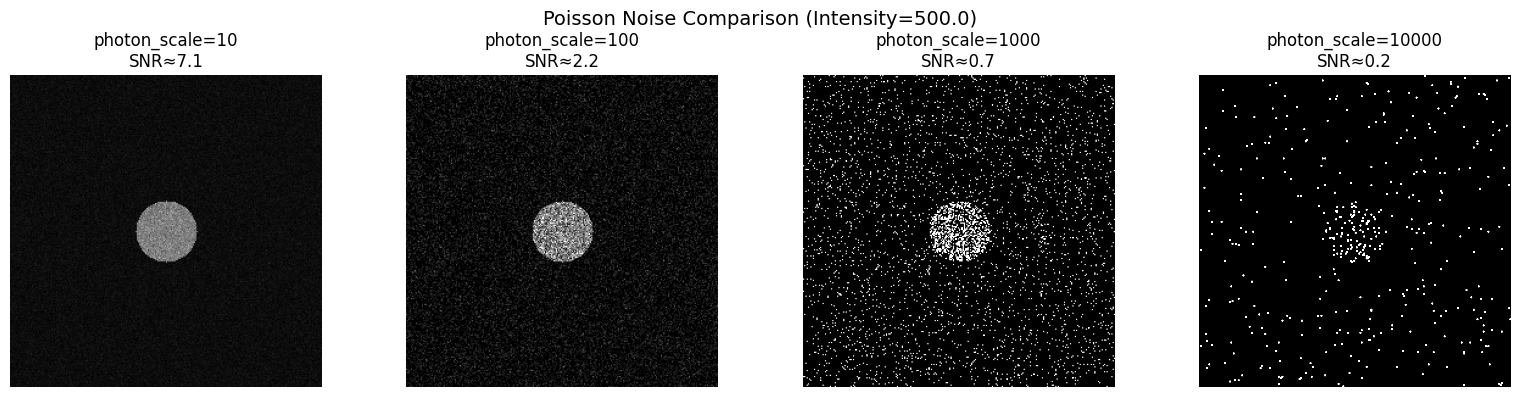

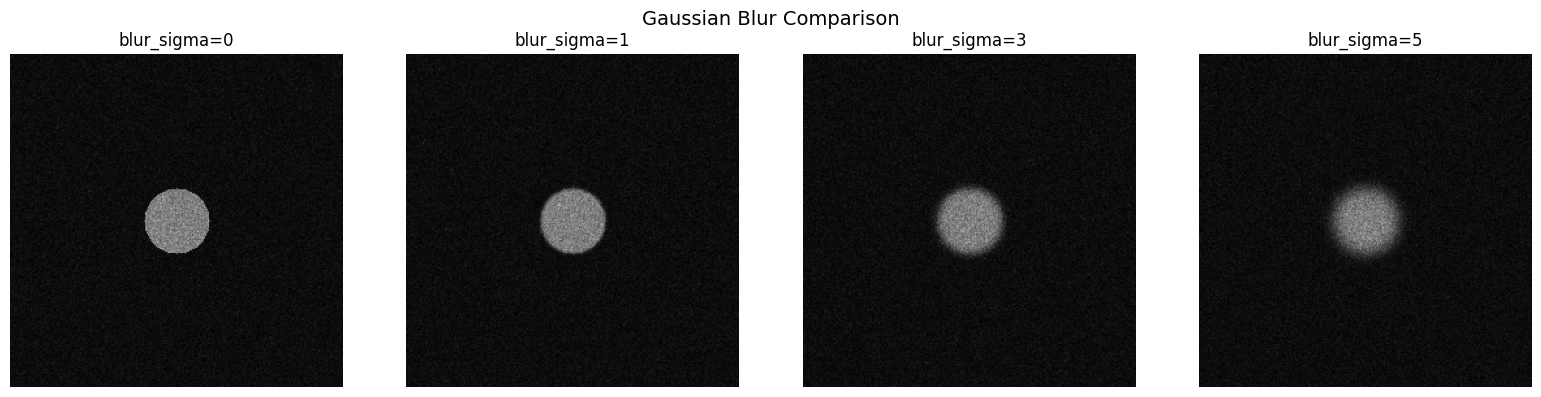

In [115]:
gen = SyntheticImageGenerator(
    output_dir=None,
    height=256,
    width=256,
    num_channels=4,
    background_intensity=50,
    dtype='uint16',
    direct_write=False
)

gen.preview_noise_comparison()

In [122]:
# Initialize generator
gen = SyntheticImageGenerator(
    output_dir=None,
    height=256,
    width=256,
    num_channels=4,
    background_intensity=300,
    dtype='uint16',
    direct_write=False
)

# Example 1: Simple morph - circle grows and brightens
print("Example 1: Growing circle")
config1 = gen.create_morph_sequence(
    shape_type='circle',
    size_start=30,
    size_end=80,
    intensity_start=200,
    intensity_end=800
)
img = gen.generate_image('morph_grow', **config1)
#print(f"Saved: {img}\n")

# Example 2: Complex morph - square moves and changes size
print("Example 2: Moving square")
config2 = gen.create_morph_sequence(
    shape_type='square',
    size_start=(40, 40),
    size_end=(70, 50),  # Different aspect ratio at end
    center_start=(100, 100),
    center_end=(156, 156),
    intensity_start=300,
    intensity_end=700,
    spatial_noise_std=1.0
)
img2 = gen.generate_image('morph_move', **config2)
#print(f"Saved: {img2}\n")

# Example 3: Random morph batch
print("Example 3: Random morph batch")
batch = gen.create_random_morph_batch(
    batch_size=10,
    param_distributions={
        'shape_type': {'dist': 'choice', 'options': ['square', 'circle']},        # {'dist': 'choice', 'options': ['square', 'circle']}
        'size': {'dist': 'uniform', 'min': 25, 'max': 45},
        'size_end': {'dist': 'dual', 'mean_1': 60, 'std_1': 5, 'mean_2': 100, 'std_2': 10},
        'intensity': {'dist': 'uniform', 'min': 150, 'max': 300},
        'intensity_end': {'dist': 'uniform', 'min': 600, 'max': 900},
        'spatial_noise_std': {'dist': 'uniform', 'min': 0, 'max': 2},
        'rotation_start': {'dist': 'uniform', 'min': 0,   'max': 360},
        'rotation_delta': {'dist': 'choice', 'options': [0, 90]}
        
    }
)
imgs = gen.generate_batch(batch, base_name='random_morph')
print(f"\nGenerated {len(imgs)} random morphing sequences")

batch = gen.create_random_morph_batch(
    batch_size=10,
    param_distributions={
        # === SHAPE/MORPHING PARAMETERS (Morphing over the time dimension/channels) ===
        'shape_type': {'dist': 'choice', 'options': ['square', 'circle']},
        
        # 1. Size Morphing
        'size': {'dist': 'uniform', 'min': 25, 'max': 45},
        'size_end': {'dist': 'dual', 'mean_1': 60, 'std_1': 5, 'mean_2': 100, 'std_2': 10},
        
        # 2. Position Morphing (Movement)
        'center_y': {'dist': 'uniform', 'min': 50, 'max': 100},              # Start Y-position
        'center_x': {'dist': 'uniform', 'min': 150, 'max': 200},             # Start X-position
        'center_y_end': {'dist': 'uniform', 'min': 150, 'max': 200},         # End Y-position
        'center_x_end': {'dist': 'uniform', 'min': 50, 'max': 100},          # End X-position
        
        # 3. Rotation Morphing
        'rotation': {'dist': 'uniform', 'min': 0, 'max': 360},
        'rotation_delta': {'dist': 'choice', 'options': [0, 45, 90, 180]},   # Total rotation over the sequence
        
        # 4. Intra-Channel (Spatial) Noise and Blur
        'spatial_noise_std': {'dist': 'uniform', 'min': 0, 'max': 2.0},      # Noise added to size/center per channel
        'blur_sigma': {'dist': 'uniform', 'min': 0.0, 'max': 0.0},           # Gaussian blur (soft edges)
        
        # === INTENSITY/GRADIENT PARAMETERS ===
        'intensity': {'dist': 'uniform', 'min': 150, 'max': 300},
        'intensity_end': {'dist': 'uniform', 'min': 600, 'max': 900},
        
        # 5. Inter-Channel Noise (Intensity Noise)
        'channel_noise_std': {'dist': 'uniform', 'min': 0, 'max': 5.0},      # Noise added to intensity per channel
        
        # 6. Sensor Noise (Poisson)
        'photon_scale': {'dist': 'fixed', 'value': 1}       # Low value = more noise, High value = less noise
    }
)
imgs2 = gen.generate_batch(batch, base_name='all_ops')

Example 1: Growing circle
Example 2: Moving square
Example 3: Random morph batch
Generating 1/10: random_morph_0000 (circle, size=44.529285188301586)
Generating 2/10: random_morph_0001 (circle, size=33.9397652399618)
Generating 3/10: random_morph_0002 (circle, size=26.473269991849342)
Generating 4/10: random_morph_0003 (circle, size=37.165341781647506)
Generating 5/10: random_morph_0004 (square, size=38.176718952346704)
Generating 6/10: random_morph_0005 (square, size=27.214276450923713)
Generating 7/10: random_morph_0006 (circle, size=40.05672615748382)
Generating 8/10: random_morph_0007 (circle, size=25.730471479693456)
Generating 9/10: random_morph_0008 (circle, size=37.60574675546643)
Generating 10/10: random_morph_0009 (square, size=42.777382115583336)

Batch complete: 10 images returned as arrays

Generated 10 random morphing sequences
Generating 1/10: all_ops_0000 (square, size=30.632044493532945)
Generating 2/10: all_ops_0001 (square, size=34.772676091106874)
Generating 3/10: a

/tmp/ipykernel_162869/1419818198.py:724: UserWarning: Photon scale must be positive, skipping Poisson noise.
  warnings.warn("Photon scale must be positive, skipping Poisson noise.")


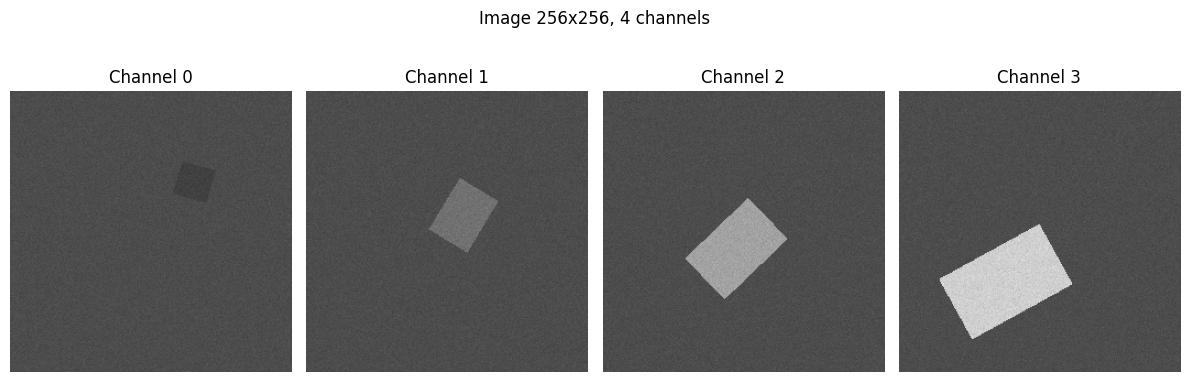

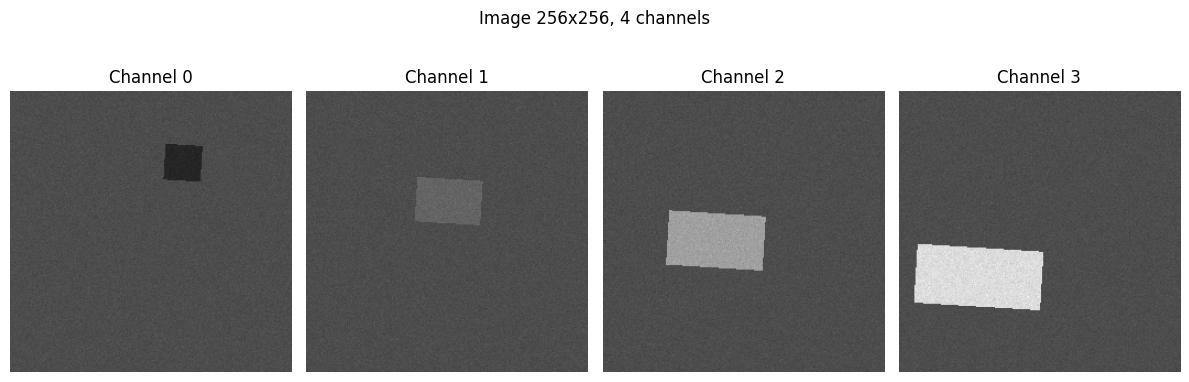

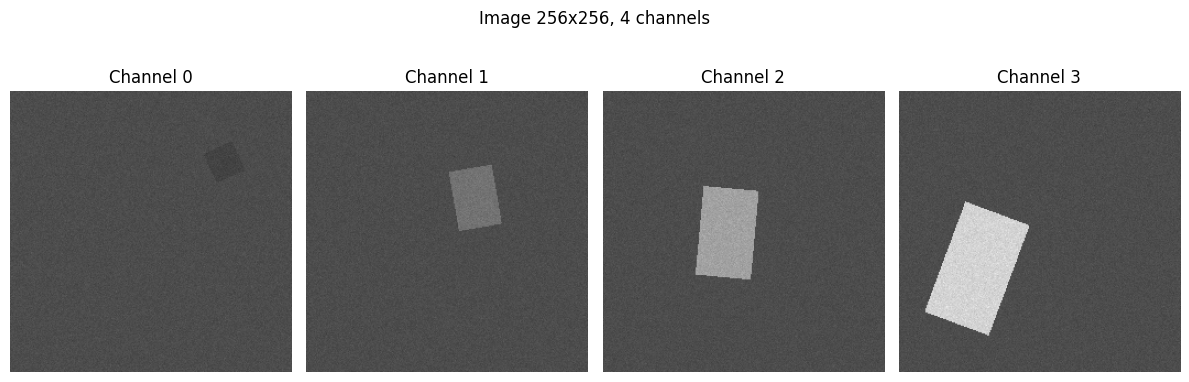

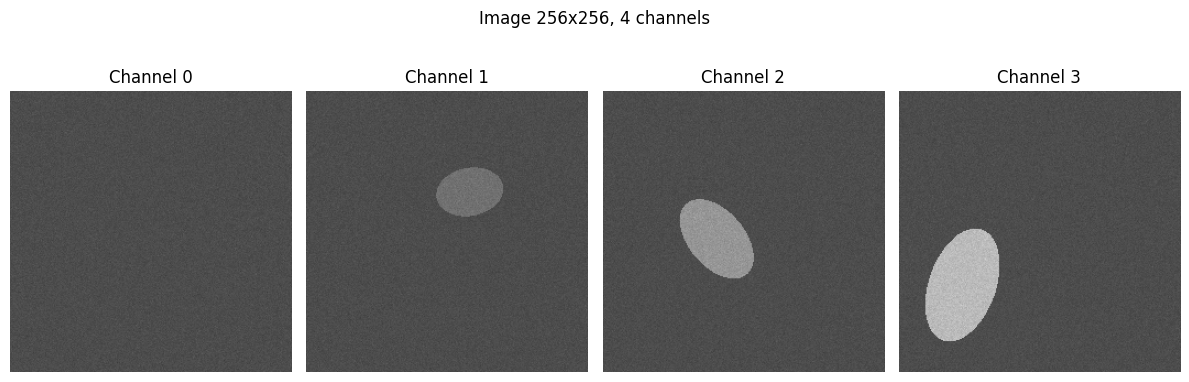

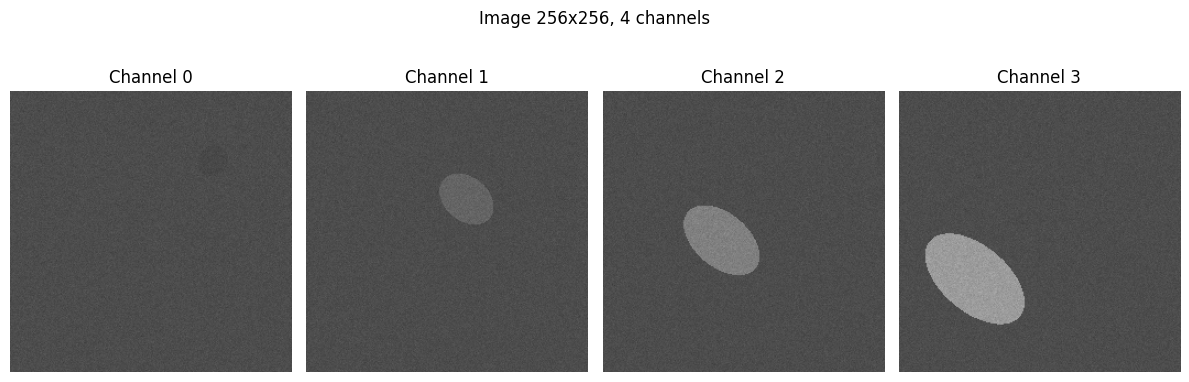

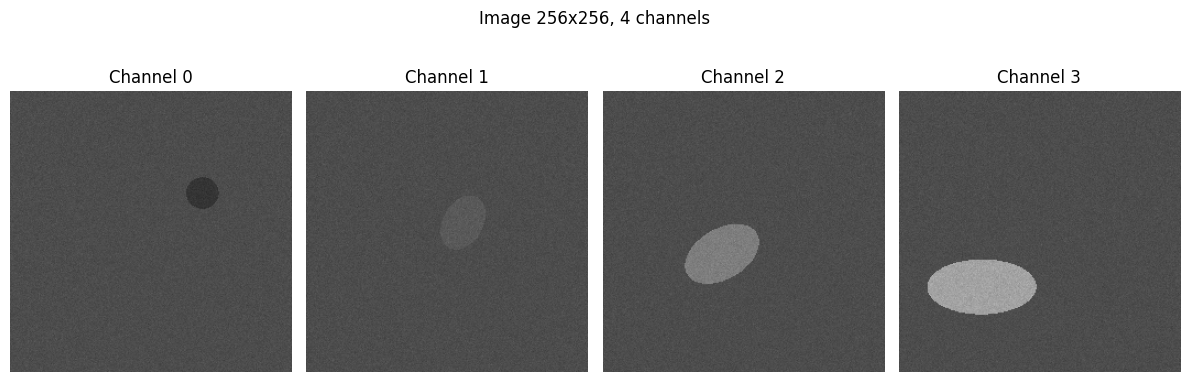

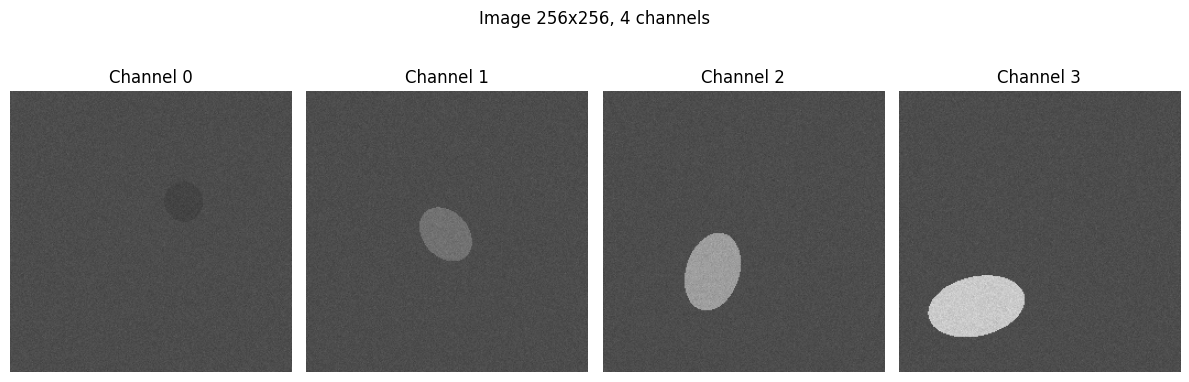

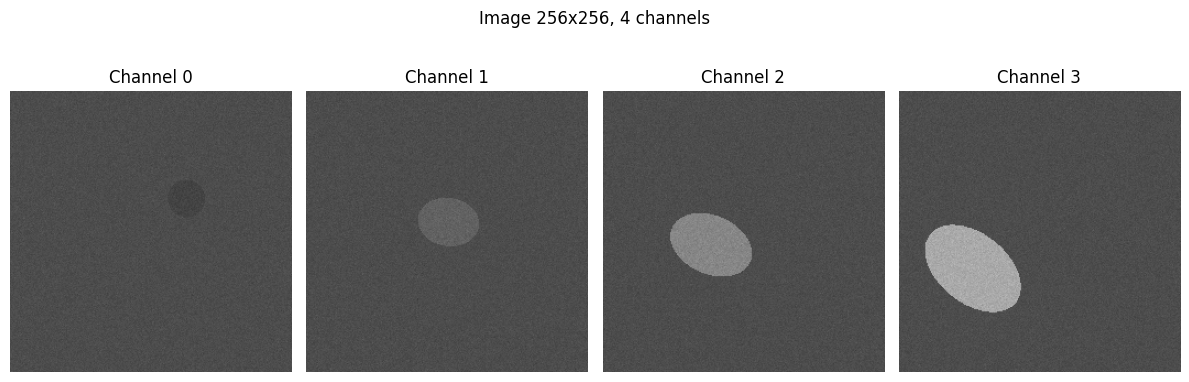

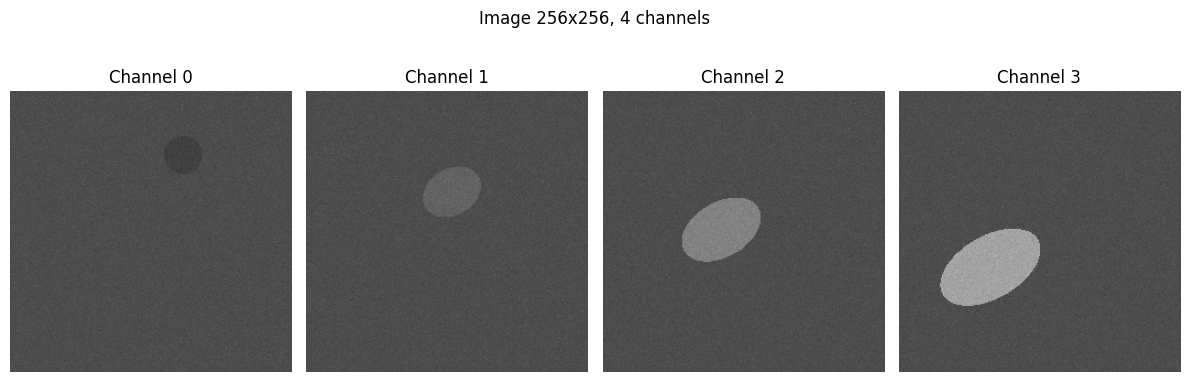

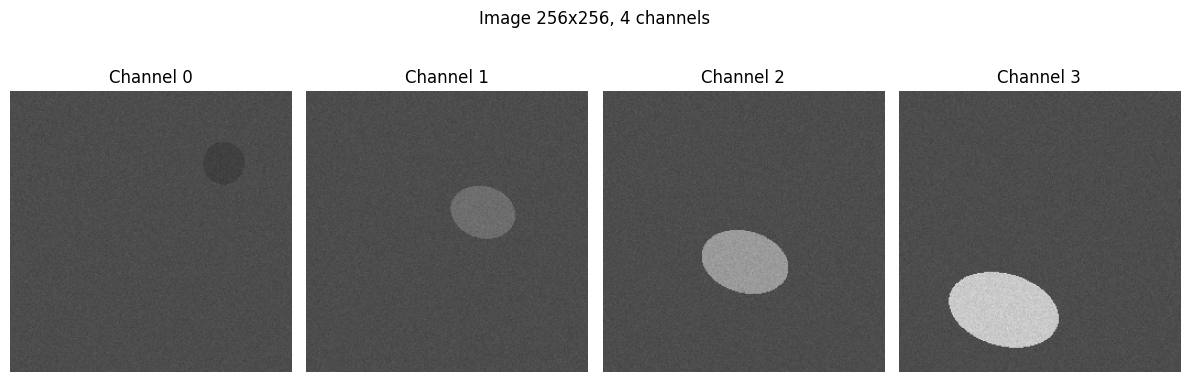

In [123]:
for image in imgs2:
    show(image)

In [201]:
import numpy as np
import tifffile
from pathlib import Path
from typing import Dict, Union, Optional, Tuple, List
import warnings


class SyntheticImageGenerator:
    """
    Enhanced synthetic multi-channel image generator.
    Now supports:
    - Squares that extend beyond image borders (automatically cropped)
    - Optional custom center position
    - Direct return mode for debugging
    """

    def __init__(
        self,
        output_dir: Union[str, Path],
        height: int,
        width: int,
        num_channels: int,
        background_intensity: float,
        dtype: str = 'uint16',
        direct_write: bool = False
    ):
        if height <= 0 or width <= 0 or num_channels <= 0:
            raise ValueError("height, width, and num_channels must be positive")

        self.output_dir = Path(output_dir)
        self.height = int(height)
        self.width = int(width)
        self.num_channels = int(num_channels)
        self.background_intensity = float(background_intensity)
        self.dtype = np.dtype(dtype)
        self.direct_write = bool(direct_write)

        self.output_dir.mkdir(parents=True, exist_ok=True)

        self._validate_intensity(background_intensity, "background_intensity")

    def _validate_intensity(self, intensity: float, name: str) -> None:
        if np.issubdtype(self.dtype, np.integer):
            info = np.iinfo(self.dtype)
            if not (info.min <= intensity <= info.max):
                raise ValueError(f"{name}={intensity} out of range for {self.dtype}")
        else:
            info = np.finfo(self.dtype)
            if abs(intensity) > info.max * 0.99:
                warnings.warn(f"{name}={intensity} close to or beyond {self.dtype} limits")

    def _calculate_square_bounds(
        self,
        side_length: int,
        center_y: Optional[int] = None,
        center_x: Optional[int] = None
    ) -> Tuple[int, int, int, int]:
        """
        Calculate square bounds, allowing it to extend beyond image edges.
        Out-of-bounds regions will be clipped later.
        """
        if side_length <= 0:
            raise ValueError("side_length must be positive")

        center_y = center_y if center_y is not None else self.height // 2
        center_x = center_x if center_x is not None else self.width // 2

        half = side_length // 2
        y_start = center_y - half
        y_end = center_y + (side_length - half)
        x_start = center_x - half
        x_end = center_x + (side_length - half)

        return y_start, y_end, x_start, x_end

    def _draw_square_mask(
        self,
        height: int,
        width: int,
        size_y: float,  # New: Height of the rectangle
        size_x: float,  # New: Width of the rectangle
        center_y: float,
        center_x: float,
    ) -> np.ndarray:
        """Calculates a boolean mask for a rectangle centered at (center_y, center_x)."""
        y_coords, x_coords = np.mgrid[0:height, 0:width]
        
        half_y = size_y / 2.0
        half_x = size_x / 2.0
        
        # Calculate mask based on coordinate ranges
        mask = (y_coords >= center_y - half_y) & \
               (y_coords < center_y + half_y) & \
               (x_coords >= center_x - half_x) & \
               (x_coords < center_x + half_x)
               
        return mask

    def _draw_circle_mask(
        self,
        height: int,
        width: int,
        size_y: float,  # New: Y-radius * 2 (Height/Major axis)
        size_x: float,  # New: X-radius * 2 (Width/Minor axis)
        center_y: float,
        center_x: float,
    ) -> np.ndarray:
        """Calculates a boolean mask for an ellipse centered at (center_y, center_x)."""
        y_coords, x_coords = np.mgrid[0:height, 0:width]
        
        radius_y = size_y / 2.0 # Half the height of the bounding box
        radius_x = size_x / 2.0 # Half the width of the bounding box
        
        # Ellipse formula: (y - cy)^2 / Ry^2 + (x - cx)^2 / Rx^2 <= 1
        # To avoid division by zero/near-zero if a size is very small:
        Ry_squared = radius_y**2
        Rx_squared = radius_x**2
        
        # If a radius is zero, the shape collapses. We should handle this:
        if Ry_squared == 0 or Rx_squared == 0:
             return np.zeros((height, width), dtype=np.bool_)

        distance_normalized = (y_coords - center_y)**2 / Ry_squared + \
                              (x_coords - center_x)**2 / Rx_squared
        mask = distance_normalized <= 1.0
               
        return mask

    def _draw_shape_mask(
        self,
        shape_type: str,
        size_y: float,  # New
        size_x: float,  # New
        center_y: float,
        center_x: float
    ) -> np.ndarray:
        """Dispatches drawing to the correct shape function."""
        shape_type = shape_type.lower()

        if shape_type == 'square': # Still called 'square' but draws a rectangle
            return self._draw_square_mask(self.height, self.width, size_y, size_x, center_y, center_x)
        elif shape_type == 'circle': # Still called 'circle' but draws an ellipse
            return self._draw_circle_mask(self.height, self.width, size_y, size_x, center_y, center_x)
        else:
            # Note: You should update this warning to reflect the new parameters
            warnings.warn(f"Unsupported shape type: {shape_type}. Default: rectangle.")
            return self._draw_square_mask(self.height, self.width, size_y, size_x, center_y, center_x)
            

    def _generate_linear_gradient(
        self,
        start_intensity: float,
        end_intensity: float,
        channel_noise_std: float
    ) -> np.ndarray:
        """
        Generates a linear ramp of intensities and adds Gaussian noise.
        The result is clipped to prevent out-of-range values.
        """
        # 1. Calculate the ideal linear ramp (base signal)
        linear_ramp = np.linspace(start_intensity, end_intensity, self.num_channels, dtype=np.float64)
        
        # 2. Generate noise term
        if channel_noise_std > 0:
            noise = np.random.normal(0, channel_noise_std, size=self.num_channels)
            # 3. Add noise to the ramp
            intensities = linear_ramp + noise
        else:
            intensities = linear_ramp

        # 4. Clip intensities to the valid range for the final dtype
        if np.issubdtype(self.dtype, np.integer):
            iinfo = np.iinfo(self.dtype)
            min_val, max_val = iinfo.min, iinfo.max
        else:
            # Assume float types clip to a standard range, e.g., 0-255 or 0-1
            min_val, max_val = 0.0, 255.0 # This should be adjusted if using float[0,1]

        # Ensure intensities stay within the bounds of the target dtype
        intensities = np.clip(intensities, min_val, max_val)
        
        return intensities

    def generate_image(
        self,
        file_name: str,
        shape_params: Dict[str, Union[int, Dict, str, float, Tuple[float, float]]], # Updated type hint
        gradient_params: Dict[str, float],
        metadata: Optional[Dict] = None
    ) -> Union[Path, np.ndarray]:
        # --- Parse shape parameters ---
        shape_type = shape_params.get('shape_type', 'square').lower()
        
        # Process the 'size' parameter
        size_input = shape_params['size'] # Use 'size' instead of 'size_param'
        
        if isinstance(size_input, (int, float)):
            # Single number
            size_y_base = float(size_input)
            size_x_base = float(size_input)
        elif isinstance(size_input, (tuple, list)) and len(size_input) == 2:
            # Tuple or list, separate x and y
            size_y_base, size_x_base = float(size_input[0]), float(size_input[1])
        else:
            raise ValueError("Size parameter must be a single number or a tuple/list of two numbers (Y, X).")
        
        center_y = self.height // 2
        center_x = self.width // 2

        spatial_noise_std = shape_params.get('spatial_noise_std', 0.0)

        # --- Read gradient config ---
        start_intensity = gradient_params['start_intensity']
        end_intensity = gradient_params['end_intensity']
        channel_noise_std = gradient_params.get('channel_noise_std', 0.0)
    
        # --- Generate gradient values ---
        intensities = self._generate_linear_gradient(
            start_intensity, 
            end_intensity,
            channel_noise_std,
        )
        
        # Validate intensities
        max_intensity = max(intensities)
        min_intensity = min(intensities)
        self._validate_intensity(max_intensity, 'max_intensity')
        self._validate_intensity(min_intensity, 'min_intensity')

        # --- Create empty image ---
        image = np.full(
            (self.num_channels, self.height, self.width),
            self.background_intensity,
            dtype=self.dtype
        )
        
        # --- Per-Channel Drawing Loop ---
        for c in range(self.num_channels):
            # 1. Apply Spatial Noise to Size and Position (Per-Channel Variation)
            if spatial_noise_std > 0:
                # Noise for position (simulating chromatic aberration)
                center_offset_y = np.random.normal(0, spatial_noise_std)
                center_offset_x = np.random.normal(0, spatial_noise_std)
            else:
                center_offset_y, center_offset_x = 0, 0
            
            current_y = int(center_y + center_offset_y)
            current_x = int(center_x + center_offset_x)

            if spatial_noise_std > 0:
                # Calculate separate noise for Y and X size
                size_offset_y = np.random.normal(0, spatial_noise_std)
                size_offset_x = np.random.normal(0, spatial_noise_std)
            else:
                size_offset_y, size_offset_x = 0.0, 0.0
            
            current_size_y = size_y_base + size_offset_y
            current_size_x = size_x_base + size_offset_x
            
            # Ensure sizes are positive
            current_size_y = max(1.0, current_size_y)
            current_size_x = max(1.0, current_size_x) 

            # 2. Get the Shape Mask (Dispatcher call remains the same, accepting Y and X)
            shape_mask = self._draw_shape_mask(
                shape_type,
                current_size_y, # Pass size_y
                current_size_x, # Pass size_x
                current_y,
                current_x
            )

            # 3. Apply intensity
            image[c, shape_mask] = intensities[c]


        # Final cast
        image = image.astype(self.dtype, copy=False)

        # --- Save or return ---
        if self.direct_write:
            if not str(file_name).lower().endswith(('.tif', '.tiff')):
                file_name = f"{file_name}.tif"
            output_path = self.output_dir / file_name

            tiff_metadata = {
                'axes': 'CYX',
                'Channel': {'Name': [f'Channel_{i}' for i in range(self.num_channels)]},
                'ImageDescription': (
                    f'Synthetic: {self.num_channels}C {self.height}x{self.width}, '
                    f'square_side={side_length}, '
                    f'center=({center_y or self.height//2},{center_x or self.width//2}), '
                    f'gradient=[{start_intensity:.1f}→{end_intensity:.1f}]'
                )
            }
            if metadata:
                tiff_metadata.update(metadata)

            tifffile.imwrite(
                output_path,
                image,
                photometric='minisblack',
                metadata=tiff_metadata
            )
            return output_path
        else:
            return image

    def generate_batch(
        self,
        batch_params: List[Dict],
        base_name: str = 'image',
        verbose: bool = True
    ) -> List[Union[Path, np.ndarray]]:
        """
        Returns list of Paths if direct_write=True, otherwise list of np.ndarrays.
        """
        results = []

        for idx, params in enumerate(batch_params):
            file_name = f"{base_name}_{idx:04d}"

            if verbose:
                side = params['shape_params']['size']
                print(f"Generating {idx+1}/{len(batch_params)}: {file_name} (square={side}px)")

            result = self.generate_image(
                file_name=file_name,
                shape_params=params['shape_params'],
                gradient_params=params['gradient_params'],
                metadata=params.get('metadata')
            )
            results.append(result)

        if verbose:
            mode = "saved to disk" if self.direct_write else "returned as arrays"
            print(f"\nBatch complete: {len(results)} images {mode}")

        return results

    def create_random_batch_instructions(
        self,
        batch_size: int,
        param_distributions: Dict[str, Dict[str, Union[str, float, Tuple[float, float], List[float]]]]
    ) -> List[Dict]:
        """
        Automatically creates a list of batch parameters by sampling from
        specified statistical distributions (uniform or normal).
        
        Note: You must now provide 'shape_type' in param_distributions, 
        or it defaults to 'square'. 'side_length' is now 'size_param'.
        """
        
        # --- Helper function for sampling based on distribution type ---
        def _sample(dist_config):
            dist_type = dist_config['dist'].lower()
            
            if dist_type == 'uniform':
                low = dist_config['min']
                high = dist_config['max']
                return np.random.uniform(low, high, size=batch_size)
            
            elif dist_type == 'normal':
                mean = dist_config['mean']
                std = dist_config['std']
                # np.abs is used to prevent negative values for inherently positive things like size_param
                return np.abs(np.random.normal(mean, std, size=batch_size))
            
            elif dist_type == 'fixed':
                return np.full(batch_size, dist_config['value'])
            
            elif dist_type == 'choice': # New distribution type for categorical choice
                return np.random.choice(dist_config['options'], size=batch_size)

            else:
                raise ValueError(f"Unknown distribution type: {dist_type}")

        # --- Define all parameters to be sampled ---
        default_params = {
            'shape_type': {'dist': 'fixed', 'value': 'square'}, # Default shape
            'size': {'dist': 'uniform', 'min': 20, 'max': min(self.height, self.width) * 0.8}, # Renamed from side_length
            'center_y': {'dist': 'fixed', 'value': self.height // 2},
            'center_x': {'dist': 'fixed', 'value': self.width // 2},
            'start_intensity': {'dist': 'uniform', 'min': self.background_intensity + 50, 'max': 255.0},
            'end_intensity': {'dist': 'uniform', 'min': self.background_intensity + 50, 'max': 255.0},
            'spatial_noise_std': {'dist': 'fixed', 'value': 0.0},
            'channel_noise_std': {'dist': 'fixed', 'value': 0.0},
        }

        # Override defaults with user-provided configurations
        full_config = {**default_params, **param_distributions}
        for key, config in param_distributions.items():
             # If the user provides 'size_y' or 'size_x', we should treat them as distinct params
             if key not in ['size_y', 'size_x']:
                 full_config[key] = config

        # Special handling: If user provides size_y and size_x, remove default 'size' and sample both
        if 'size_y' in param_distributions and 'size_x' in param_distributions:
             full_config.pop('size', None)
             full_config['size_y'] = param_distributions.get('size_y', {'dist': 'fixed', 'value': default_params['size']['max']})
             full_config['size_x'] = param_distributions.get('size_x', {'dist': 'fixed', 'value': default_params['size']['max']})
        
        # --- Sample all parameters in vectorized fashion ---
        sampled_data = {}
        for key, config in full_config.items():
            sampled_data[key] = _sample(config)
        
        # --- Assemble instructions into the required structure ---
        batch_instructions = []
        for i in range(batch_size):
            
            # Collect and cast/clip all sampled parameters
            shape_type = sampled_data['shape_type'][i]
            if 'size' in full_config:
                final_size = sampled_data['size'][i]
            else:
                # If size_y/size_x were explicitly sampled (for morphing)
                final_size = (sampled_data['size_y'][i], sampled_data['size_x'][i])
            center_y = int(sampled_data['center_y'][i])
            center_x = int(sampled_data['center_x'][i])
            spatial_noise_std = sampled_data.get('spatial_noise_std', [0.0])[i]
            channel_noise_std = sampled_data.get('channel_noise_std', [0.0])[i]

            start_i = np.clip(sampled_data['start_intensity'][i], 0, np.iinfo(self.dtype).max if np.issubdtype(self.dtype, np.integer) else 255.0)
            end_i = np.clip(sampled_data['end_intensity'][i], 0, np.iinfo(self.dtype).max if np.issubdtype(self.dtype, np.integer) else 255.0)

            instruction = {
                'shape_params': { # Renamed
                    'shape_type': shape_type,
                    'size': final_size, # Renamed
                    'center': (center_y, center_x),
                    'spatial_noise_std': spatial_noise_std,
                },
                'gradient_params': {
                    'start_intensity': start_i,
                    'end_intensity': end_i,
                    'channel_noise_std': channel_noise_std,
                }
            }
            batch_instructions.append(instruction)

        return batch_instructions




In [205]:
# ============================
# Example usage
# ============================
gen = SyntheticImageGenerator(
    output_dir='./synthetic_data',
    height=256,
    width=256,
    num_channels=4,
    background_intensity=0,
    dtype='uint16',
    direct_write=False  # ← keep this False during development!
)

# This square is HUGE and off-center → will be cropped
img = gen.generate_image(
    file_name='huge_offcenter',
    shape_params={
        'size': 300,           # bigger than image!
        #'center': (0, 0)              # way off-center
    },
    gradient_params={
        'start_intensity': 500,
        'end_intensity': 500
    }
)


# Batch example with some oversized squares
instructions_normal = gen.create_random_batch_instructions(
    batch_size=5,
    param_distributions={
        'size': {'dist': 'normal', 'mean': 100, 'std': 10},
        'shape_type' : {'dist': 'choice', 'options': ['square']},
        #'center_y': {'dist': 'normal', 'mean': 128, 'std': 20},
        #'center_x': {'dist': 'normal', 'mean': 128, 'std': 20},
        # Always have a steep, increasing gradient for this batch/class
        'start_intensity': {'dist': 'fixed', 'value': 50},
        'end_intensity': {'dist': 'normal', 'mean': 400, 'std': 50},
    }
)
instructions_full_params = gen.create_random_batch_instructions(
    batch_size=6, # Generate 10 instruction sets
    param_distributions={
        # 1. Shape Type: Choose randomly between a square and a circle
        'shape_type': {'dist': 'choice', 'options': ['square', 'circle']},

        # 2. Size Parameter (Side Length/Diameter): Normally distributed around 150px
        'size_y': {'dist': 'normal', 'mean': 150, 'std': 20},
        'size_x': {'dist': 'normal', 'mean': 50, 'std': 10},

        # 3. Center Y Position: Uniformly distributed across the top half of the image
        'center_y': {'dist': 'uniform', 'min': 120, 'max': 130},

        # 4. Center X Position: Fixed at the center X-axis
        'center_x': {'dist': 'uniform', 'min': 120, 'max': 130},

        # 5. Start Intensity: Normally distributed around 100
        'start_intensity': {'dist': 'normal', 'mean': 100, 'std': 15},

        # 6. End Intensity: Fixed value of 500 (assuming high dynamic range dtype like uint16)
        'end_intensity': {'dist': 'fixed', 'value': 500},

        # 7. Spatial Noise STD: Jitter for position/size is uniformly random
        # This simulates random chromatic aberration and shape blur per channel
        'spatial_noise_std': {'dist': 'uniform', 'min': 0.5, 'max': 2.0},

        # 8. Channel Noise STD: Fixed level of Gaussian noise added to the gradient
        # This simulates random intensity flicker/variation per channel
        'channel_noise_std': {'dist': 'fixed', 'value': 10.0},
    }
)
images = gen.generate_batch(instructions_normal, base_name='normal_class_A')
images_2 = gen.generate_batch(instructions_full_params, base_name='normal_class_B')

Generating 1/5: normal_class_A_0000 (square=103.17113676412794px)
Generating 2/5: normal_class_A_0001 (square=95.68945223499767px)
Generating 3/5: normal_class_A_0002 (square=78.25996190714157px)
Generating 4/5: normal_class_A_0003 (square=98.33166582776698px)
Generating 5/5: normal_class_A_0004 (square=112.89242038253923px)

Batch complete: 5 images returned as arrays
Generating 1/6: normal_class_B_0000 (square=(140.932596154793, 66.6616190121072)px)
Generating 2/6: normal_class_B_0001 (square=(192.90346957228888, 53.33751875545333)px)
Generating 3/6: normal_class_B_0002 (square=(159.06333865497248, 49.058782371039236)px)
Generating 4/6: normal_class_B_0003 (square=(181.74292666903926, 43.613697341624146)px)
Generating 5/6: normal_class_B_0004 (square=(128.8318077386984, 45.50671578234418)px)
Generating 6/6: normal_class_B_0005 (square=(147.87513905920167, 39.71215270490918)px)

Batch complete: 6 images returned as arrays


In [207]:
def show(img):
    """Quickly visualize all channels of a synthetic image returned by your generator"""
    plt.figure(figsize=(12, 8))
    for c in range(img.shape[0]):
        plt.subplot(2, 4, c + 1)
        plt.imshow(img[c], cmap='gray', vmin=0, vmax=1000)
        plt.title(f'Channel {c}')
        plt.axis('off')
    plt.suptitle(f"Image {img.shape[1]}x{img.shape[2]}, {img.shape[0]} channels")
    plt.tight_layout()
    plt.show()

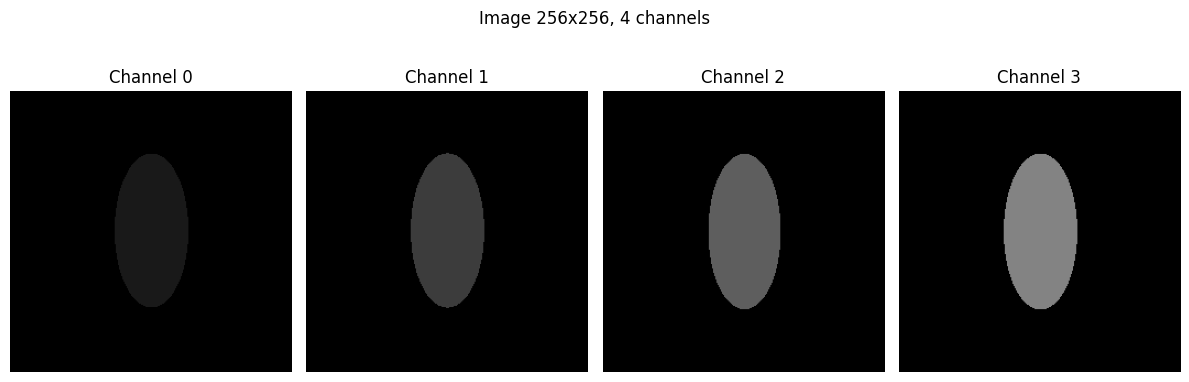

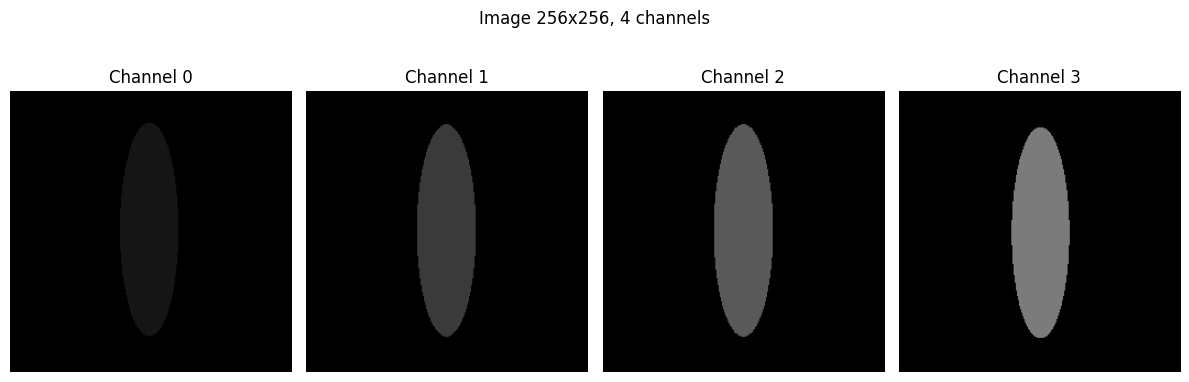

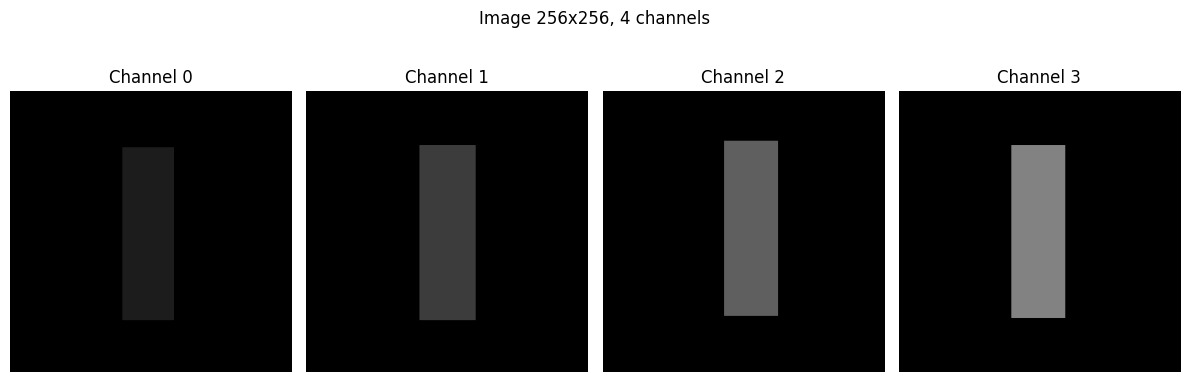

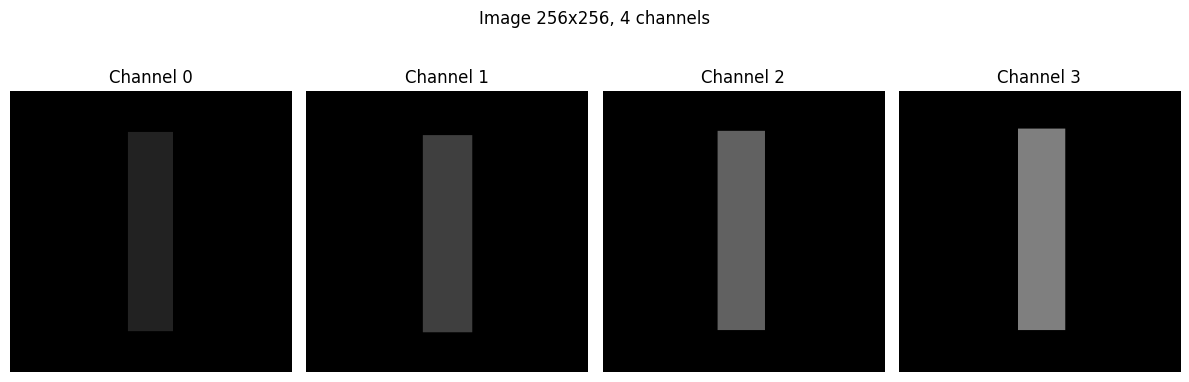

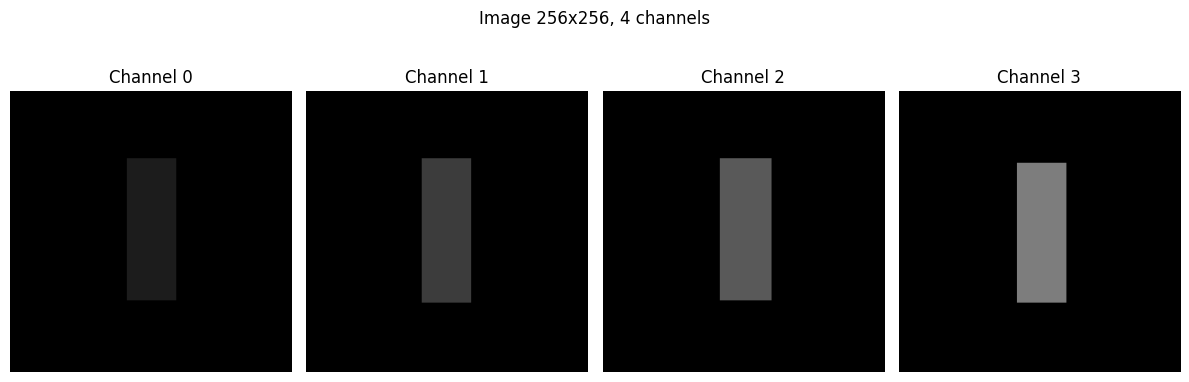

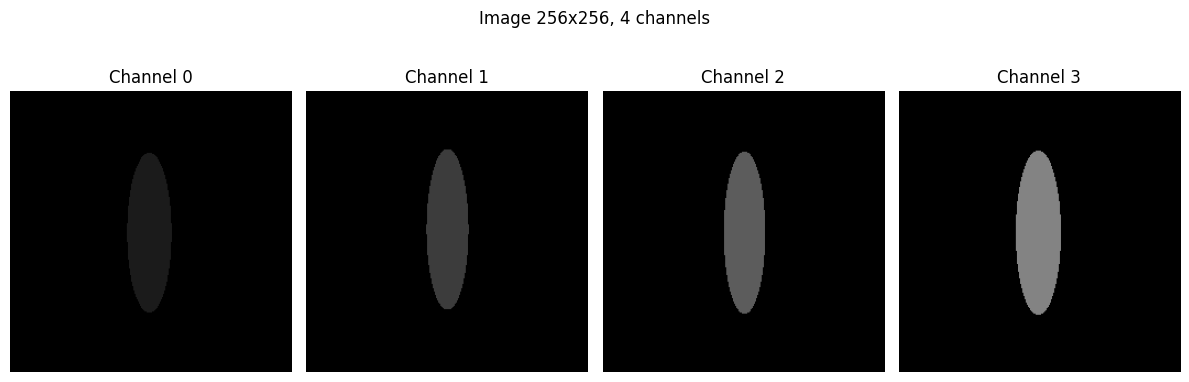

In [208]:
for image in images_2:
    show(image)

In [139]:
np.unique(img)

array([500], dtype=uint16)

In [65]:
img.shape

(8, 256, 256)

In [58]:
import os
import pandas as pd

track_df_base = '/home/nbahou/myimaging/apoDet/data/dataset2/track_dfs'

track_df_paths = os.listdir(track_df_base)

all_lengths = []
all_num_images = []

for path in track_df_paths:
    print(path)
    track_df = pd.read_csv(track_df_base + '/' + path)
    track_ids = track_df['track_id']
    
    track_lengths = track_ids.value_counts()
        
    filtered_track_lengths = track_lengths.values[track_lengths.values > 60]    
    
    if filtered_track_lengths[0] > 500:
        mean_length = filtered_track_lengths.mean()
    else:
        mean_length = filtered_track_lengths.mean() * 5

    num_images_min = mean_length / 60

    all_lengths.append(mean_length)
    all_num_images.append(num_images_min)
    
    print(f"\t{mean_length}")
    print(f"\t{num_images_min}")


mean_lengths = sum(all_lengths)/len(all_lengths)
mean_num_images = sum(all_num_images)/len(all_num_images)

print(f"\t{mean_lengths}")
print(f"\t{mean_num_images}")

    

Exp15_Site46.csv
	1414.0765492102064
	23.567942486836774
Exp01_Site07.csv
	785.4523076923077
	13.090871794871795
Exp07_Site12.csv
	1048.7445466491458
	17.479075777485765
Exp09_Site05.csv
	843.1217712177122
	14.052029520295203
Exp11_Site12.csv
	856.2542080276219
	14.270903467127031
Exp17_Site07.csv
	923.9627633512983
	15.399379389188306
Exp08_Site08.csv
	634.2450090744102
	10.57075015124017
Exp15_Site41.csv
	1437.2174590802806
	23.953624318004678
Exp09_Site02.csv
	832.8681055155876
	13.88113509192646
Exp15_Site33.csv
	1326.6908517350157
	22.111514195583595
Exp08_Site06.csv
	645.1791787639984
	10.752986312733306
Exp16_Site03.csv
	1194.0247678018577
	19.90041279669763
Exp01_Site09.csv
	718.1212553495008
	11.968687589158346
Exp15_Site48.csv
	1427.8344136711846
	23.797240227853077
Exp08_Site01.csv
	614.3384491114701
	10.238974151857835
Exp15_Site34.csv
	1361.4008620689654
	22.69001436781609
Exp03_Site01.csv
	697.6690647482014
	11.627817745803357
Exp15_Site01.csv
	1369.192942942943
	22.81988

In [49]:
track_df_paths[0]

'Exp15_Site46.csv'

In [48]:
(track_lengths.values[track_lengths.values > 25].mean() * 5)

1575.9842064714944

In [60]:
import os
from pathlib import Path

def get_dir_size(start_path: str = '.') -> int:
    """
    Calculates the total size (in bytes) of a folder and all its subdirectories 
    and files.
    """
    total_size = 0
    
    # Use os.walk or Path.glob for simplicity, but os.scandir is often 
    # more efficient for this specific task. We'll use os.walk for 
    # cross-platform compatibility and simplicity in this example.
    
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # Skip symbolic links and files the user might not have permission to access
            if not os.path.islink(fp) and os.path.exists(fp):
                try:
                    # os.path.getsize() returns the size of the file in bytes
                    total_size += os.path.getsize(fp)
                except OSError as e:
                    # Handle cases where file access fails (e.g., permission error)
                    print(f"Error accessing file {fp}: {e}")
                    pass
    return total_size

def format_size(size_bytes: int) -> str:
    """Converts a size in bytes into a human-readable format."""
    if size_bytes == 0:
        return "0 Bytes"
    
    # Define the size units
    size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # Calculate the index for the unit
    i = 0
    while size_bytes >= 1024 and i < len(size_name) - 1:
        size_bytes /= 1024
        i += 1
        
    return f"{size_bytes:.2f} {size_name[i]}"

# --- Usage Example ---
folder_path = '/home/nbahou/myimaging/apoDet_refactored/data/agne_data_50x_trk_pik_h1047r/windows_20x_2cat_resize_128' # <-- **Replace with the actual folder path**

# If you want to check the current directory:
# folder_path = '.' 

print(f"Calculating size for: {folder_path}...")

# 1. Get the total size in bytes
size_in_bytes = get_dir_size(folder_path)

# 2. Format the output
human_readable_size = format_size(size_in_bytes)

print("-" * 30)
print(f"Total Size: {human_readable_size}")
print(f"Total Bytes: {size_in_bytes} bytes")
print("-" * 30)

Calculating size for: /home/nbahou/myimaging/apoDet_refactored/data/agne_data_50x_trk_pik_h1047r/windows_20x_2cat_resize_128...
------------------------------
Total Size: 203.54 GB
Total Bytes: 218552679805 bytes
------------------------------
